In [1]:
!pip install "git+https://github.com/finegrain-ai/refiners.git@main#egg=refiners[training]"


  Cloning https://github.com/finegrain-ai/refiners.git (to revision main) to c:\users\alexa\appdata\local\temp\pip-install-8x5rgpfl\refiners_da5602504c8a45409c411d8469be0fc9
  Resolved https://github.com/finegrain-ai/refiners.git to commit d288e94fa8eed1386bd28cd0d5ceb8109c3ff398
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


DEPRECATION: git+https://github.com/finegrain-ai/refiners.git@main#egg=refiners[training] contains an egg fragment with a non-PEP 508 name. pip 25.1 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/13157
  Running command git clone --filter=blob:none --quiet https://github.com/finegrain-ai/refiners.git 'C:\Users\alexa\AppData\Local\Temp\pip-install-8x5rgpfl\refiners_da5602504c8a45409c411d8469be0fc9'


In [2]:
!pip install h5py
!pip install matplotlib
!pip install scipy

In [3]:
# Testing out raw h5 data of Event 11707158 from https://dasway.ess.washington.edu/gci/events/2023-06-10/index.html
import h5py
import matplotlib.pyplot as plt
import os
import numpy as np

In [4]:
file_path = os.path.join("testData", "KKFLS.h5")

# Load the data
f = h5py.File(file_path, 'r')

# Get dimensions of data
data = f['Acquisition/Raw[0]/RawData'][:] # numpy array
data_time = f['Acquisition/Raw[0]/RawDataTime'][:]
data_sample_count = f['Acquisition/Raw[0]/RawDataSampleCount'][:]

print(f"Data shape: {data.shape}")
print(f"DataTime shape: {data_time.shape}")
print(f"DataSampleCount shape: {data_sample_count.shape}")

Data shape: (3000, 8531)
DataTime shape: (3000,)
DataSampleCount shape: (3000,)


In [5]:
# convert epoch time to datetime
# data_time = np.array([np.datetime64(int(x), 's') for x in data_time])
# convert epoch time to seconds
data_time = np.array([(x - data_time[0]).astype('timedelta64[s]').astype(int) for x in data_time])

In [6]:
# Test plotting
data2 = data[:1000,:1000]
print(data2.shape)

print("Minimum value:", np.min(data2)) 
print("Maximum value:", np.max(data2)) 
print("Mean value:", np.mean(data2)) 
print("Unique values:", np.unique(data2))

(1000, 1000)
Minimum value: -136.17287
Maximum value: 130.44748
Mean value: 0.47792816
Unique values: [-136.17287  -109.623375 -109.14452  ...  119.6782    122.22488
  130.44748 ]


In [7]:
sampling_rate = 50  # 50 Hz
time_vector = np.arange(0, data.shape[0] / sampling_rate, 1 / sampling_rate)
print(time_vector)

[0.000e+00 2.000e-02 4.000e-02 ... 5.994e+01 5.996e+01 5.998e+01]


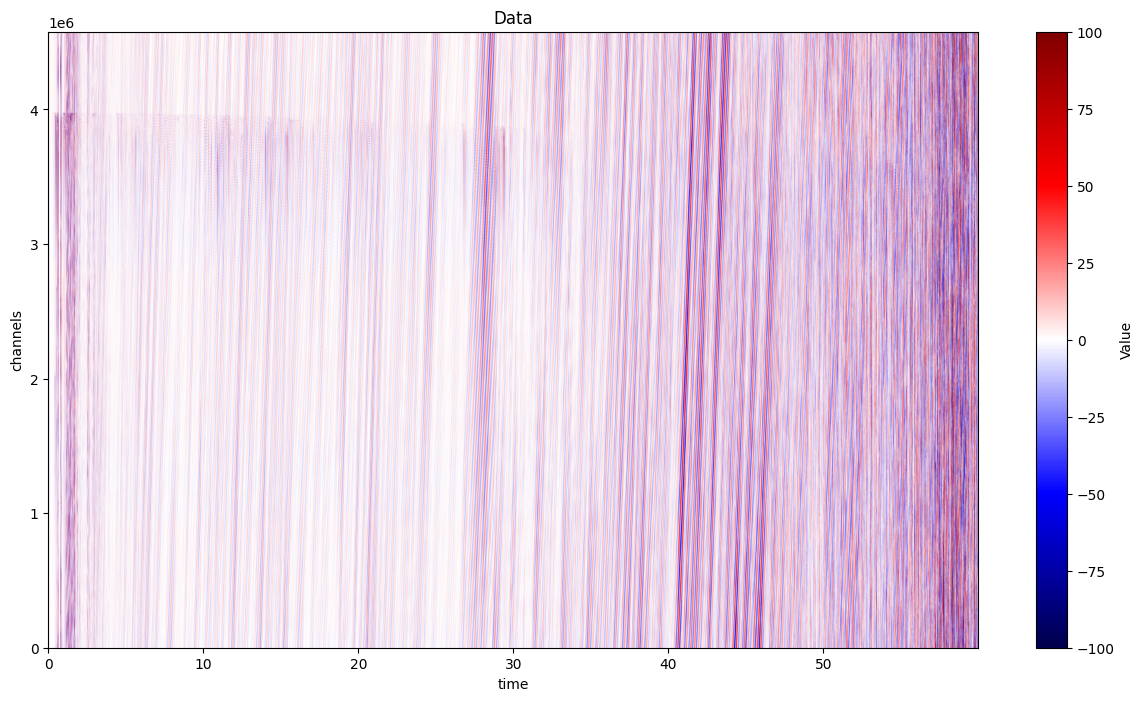

In [8]:
plt.figure(figsize=(15, 8)) # Adjust the figure size as needed 
# cap the values to 1e-3
# first dimension is time for 3000 samples and 200 Hz data
# second dimension is the number of channels

plt.imshow(data, aspect='auto', cmap='seismic',vmin=-1e2, vmax=1e2,extent=[0, time_vector[-1], 0, data_sample_count[-1]]) 
plt.colorbar(label='Value') # Add a colorbar for reference 
plt.title("Data") 
plt.xlabel("time")
plt.ylabel("channels")
plt.show()

In [9]:
from scipy.signal import butter, filtfilt

def highpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data, axis=0)
    return y

# Apply high-pass filter to the data
cutoff_frequency = 1  # 1 Hz
filtered_data = highpass_filter(data, cutoff_frequency, sampling_rate)

Text(0, 0.5, 'Channels')

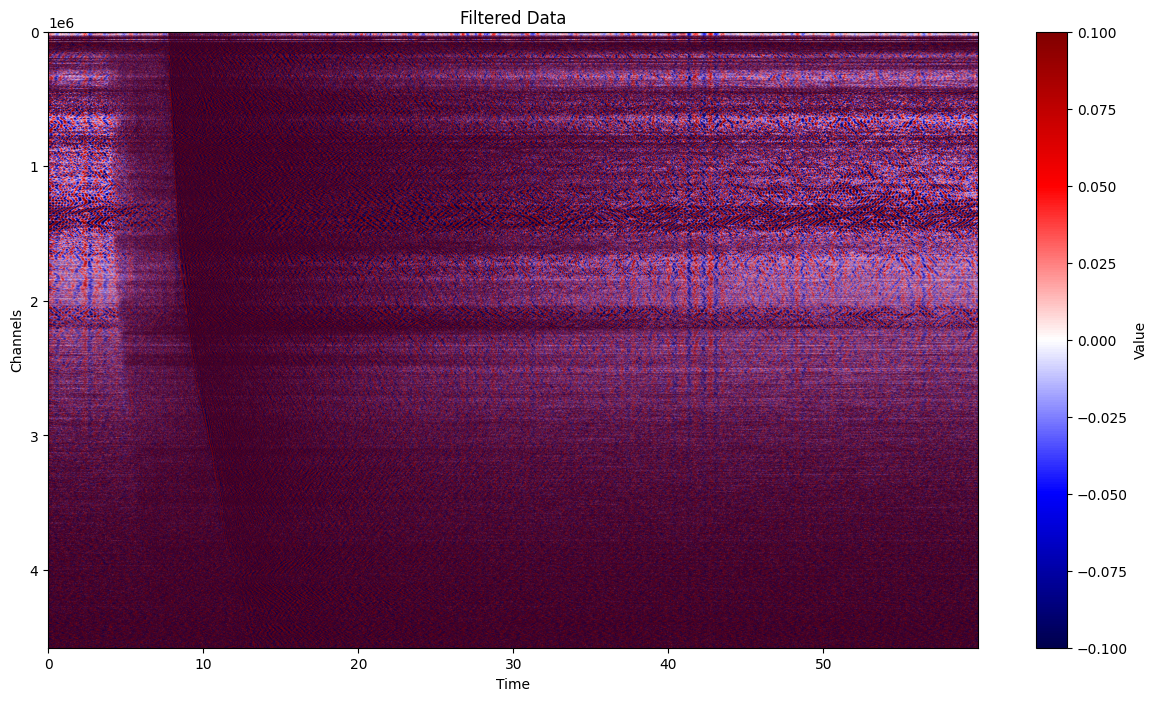

In [10]:
# plot the filtered data
plt.figure(figsize=(15, 8))
plt.imshow(filtered_data.T, aspect='auto', cmap='seismic', vmin=-1e-1, vmax=1e-1, extent=[0, time_vector[-1],  data_sample_count[-1],0])
plt.colorbar(label='Value')
plt.title("Filtered Data")
plt.xlabel("Time")
plt.ylabel("Channels")

In [ ]:
# Function to process and plot data from h5 files
def process_and_plot_h5_files(h5_files, cutoff_frequency, sampling_rate, plot_folder='plots'):
    for file in h5_files:
        # Load the data
        f = h5py.File(file, 'r')
        data = f['Acquisition/Raw[0]/RawData'][:]  # numpy array
        data_time = f['Acquisition/Raw[0]/RawDataTime'][:]
        data_sample_count = f['Acquisition/Raw[0]/RawDataSampleCount'][:]

        # Convert epoch time to seconds
        data_time = np.array([(x - data_time[0]).astype('timedelta64[s]').astype(int) for x in data_time])

        # Apply high-pass filter to the data
        filtered_data = highpass_filter(data, cutoff_frequency, sampling_rate)

        # Create time vector for plotting
        time_vector = np.arange(0, data.shape[0] / sampling_rate, 1 / sampling_rate)

        # Plot the filtered data
        plt.figure(figsize=(15, 8))
        plt.imshow(filtered_data.T, aspect='auto', cmap='seismic', vmin=-1e-1, vmax=1e-1, extent=[0, time_vector[-1], data_sample_count[-1], 0])
        plt.colorbar(label='Value')
        plt.title(f"Filtered Data from {os.path.basename(file)}")
        plt.xlabel("Time")
        plt.ylabel("Channels")

        # Save the plot as an image
        plot_filename = os.path.join(plot_folder, f"{os.path.basename(file).split('.')[0]}.png")
        plt.savefig(plot_filename)
        plt.close()

# Process and plot all h5 files
#process_and_plot_h5_files(h5_files, cutoff_frequency, sampling_rate)

In [12]:
from refiners.solutions import BoxSegmenter
from PIL import Image
import glob

h5_folder = "/Users/alexa/OneDrive/Documents/GitHub/curatedDAS/testData"  # Change this to your folder path
h5_files = glob.glob(os.path.join(h5_folder, "*.h5"))  

for file in h5_files:
    # Load the data
    f = h5py.File(file, 'r')
    data = f['Acquisition/Raw[0]/RawData'][:]  # numpy array
    data_time = f['Acquisition/Raw[0]/RawDataTime'][:]
    data_sample_count = f['Acquisition/Raw[0]/RawDataSampleCount'][:]

    # Convert epoch time to seconds
    data_time = np.array([(x - data_time[0]).astype('timedelta64[s]').astype(int) for x in data_time])

    # Apply high-pass filter to the data
    filtered_data = highpass_filter(data, cutoff_frequency, sampling_rate)

    # Create time vector for plotting
    time_vector = np.arange(0, data.shape[0] / sampling_rate, 1 / sampling_rate)

    #Normalize the filtered data to the range [0, 255]
    normalized_data = 255 * (filtered_data - np.min(filtered_data)) / (np.max(filtered_data) - np.min(filtered_data))
    normalized_data = normalized_data.astype(np.uint8)

    # Convert the normalized data to an image
    image = Image.fromarray(normalized_data.T)
    #image.show()
    # Save the image

    # Create a BoxSegmenter object
    segmenter = BoxSegmenter()
    # Segment the image
    mask = segmenter(image.convert("RGB"))
    #mask.show()

    #Save the mask as an image and image as well
    image_filename = os.path.join(h5_folder, f"{os.path.basename(file).split('.')[0]}_imageT.png")
    mask_filename = os.path.join(h5_folder, f"{os.path.basename(file).split('.')[0]}_maskT.png")
    mask.save(mask_filename)

c:\Users\alexa\OneDrive\Documents\GitHub\curatedDAS\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
